In [1]:
# ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random

import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

#学習データ
x_train = np.load('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalAssignment/data/x_train.npy')
t_train = np.load('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalAssignment/data/t_train.npy')

#テストデータ
x_test = np.load('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalAssignment/data/x_test.npy')
t_test = np.load('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalAssignment/data/t_test.npy')

class train_dataset(torch.utils.data.Dataset):
    def __init__(self, x_train, t_train):
        data = x_train.astype('float32')
        self.x_train = []
        for i in range(data.shape[0]):
            self.x_train.append(Image.fromarray(np.uint8(data[i].squeeze(-1))))
        self.t_train = t_train
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.transform(self.x_train[idx]), torch.tensor(t_train[idx], dtype=torch.long)

class test_dataset(torch.utils.data.Dataset):
    def __init__(self, x_test):
        data = x_test.astype('float32')
        self.x_test = []
        for i in range(data.shape[0]):
            self.x_test.append(Image.fromarray(np.uint8(data[i].squeeze(-1))))
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.x_test)

    def __getitem__(self, idx):
        return self.transform(self.x_test[idx])

trainval_data = train_dataset(x_train, t_train)
test_data = train_dataset(x_test, t_test)      #評価するため

In [3]:
print(x_train.shape)
print(t_test.shape)

(50000, 32, 32, 1)
(10000,)


In [10]:
def fix_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


fix_seed(seed=42)


class gcn():
    def __init__(self):
        pass

    def __call__(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean)/(std + 10**(-6))  # 0除算を防ぐ


class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="cuda"):  # 計算が重いのでGPUを用いる
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):  # 変換行列と平均をデータから計算
        x = images[0][0].reshape(1, -1)
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = images[i][0].reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        self.E, self.V = torch.linalg.eigh(con_matrix)  # 固有値分解
        self.E = torch.max(self.E, torch.zeros_like(self.E)) # 誤差の影響で負になるのを防ぐ
        self.ZCA_matrix = torch.mm(torch.mm(self.V, torch.diag((self.E.squeeze()+self.epsilon)**(-0.5))), self.V.t())
        print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x


# (datasetのクラスを自作したので，このあたりの処理が少し変わっています)

zca = ZCAWhitening()
zca.fit(trainval_data)          #これはトレーニングデータについてのみ行う

val_size = 10000
train_data, val_data = torch.utils.data.random_split(trainval_data, [len(trainval_data)-val_size, val_size])  # 訓練データと検証データに分割


# 前処理を定義
transform_train = transforms.Compose([transforms.ToTensor(), zca])# WRITE ME

transform = transforms.Compose([transforms.ToTensor(), zca])# WRITE ME

# このままではきちんと前処理がtrainval_dataに適用されるのか？
# データセットに前処理を設定
trainval_data.transform = transform_train       #for train_data and val_data
test_data.transform = transform

batch_size = 128

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)


0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!


In [12]:
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F

rng = np.random.RandomState(1234)
random_state = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


conv_net = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.23),                       #追加


    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.4),                       #追加


    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.31),                       #追加


    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.3),                       #追加


    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.AvgPool2d(kernel_size=2, stride=2),  #元は最大値プーリング
    nn.Dropout(0.27),                       #追加

    nn.Flatten(),
    nn.Linear(512, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 12)  # 最終的な出力クラス数は12（時間）
)   #VGG16を実装


def init_weights(m):  # Heの初期化
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)


conv_net.apply(init_weights)
#conv.load_state_dict(torch.load('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/Lecture5_sub/model_weight.pth'))

n_epochs = 5
lr = 0.001
device = 'cuda'

conv_net.to(device)
optimizer = optim.Adam(conv_net.parameters(), lr=lr)# WRITE ME
loss_function = nn.CrossEntropyLoss()# WRITE ME ここでsoftmax関数の仕組みがあるのでconv_netに入れなくてよかった。

In [13]:
for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []

    conv_net.train()
    n_train = 0
    acc_train = 0
    accmax = 0  #accuracyの最大を保存
    for x, t in dataloader_train:
        # WRITE ME
        n_train += t.size()[0]

        conv_net.zero_grad()  # 勾配の初期化

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)

        y = conv_net.forward(x)  # 順伝播

        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        loss.backward()  # 誤差の逆伝播

        optimizer.step()  # パラメータの更新

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())

    conv_net.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        # WRITE ME
        n_val += t.size()[0]

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)

        y = conv_net.forward(x)  # 順伝播

        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())

        #最大値の時の重みを保存
        if acc_val/n_val > accmax:
            torch.save(conv_net.state_dict(), 'drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalAssignment/model_weightValid.pth')
            accmax = acc_val / n_val


    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
        epoch,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val
    ))

EPOCH: 0, Train [Loss: 1.684, Accuracy: 0.362], Valid [Loss: 1.037, Accuracy: 0.451]
EPOCH: 1, Train [Loss: 0.558, Accuracy: 0.758], Valid [Loss: 0.405, Accuracy: 0.852]
EPOCH: 2, Train [Loss: 0.264, Accuracy: 0.893], Valid [Loss: 0.182, Accuracy: 0.922]
EPOCH: 3, Train [Loss: 0.228, Accuracy: 0.904], Valid [Loss: 0.128, Accuracy: 0.933]
EPOCH: 4, Train [Loss: 0.217, Accuracy: 0.905], Valid [Loss: 0.283, Accuracy: 0.897]


In [14]:
torch.save(conv_net.state_dict(), 'drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalAssignment/model_weightValid.pth')

In [16]:
#評価
model = conv_net
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalAssignment/model_weightValid.pth", map_location=device))
model = model.to(device)
model.eval()
n_val = 0
acc_val = 0
i = 0
for x, t in dataloader_valid:
    i += 1
    # WRITE ME
    n_val += t.size()[0]

    x = x.to(device)  # テンソルをGPUに移動
    t = t.to(device)

    y = model.forward(x)  # 順伝播

    # loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

    # if i%10==0:
    #     print('i = {}'.format(i), t)
    pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

    acc_val += (pred == t).float().sum().item()
print(i)
print('Test : Accuracy: {:.3f}]'.format(acc_val/n_val))

79
Test : Accuracy: 0.897]


In [9]:
import matplotlib.pyplot as plt
def pt_plt(table):
    height = len(table)
    width = len(table[0])

    # plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    for i in range(height):
        for j in range(width):
            if table[i][j][0]:
                plt.scatter(j/width, i/height, color='black', marker = 's')
    plt.show()

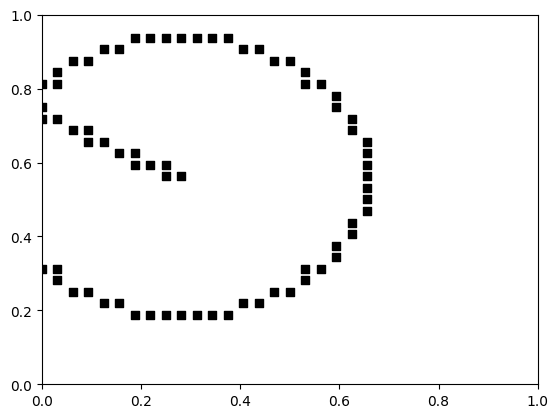

10


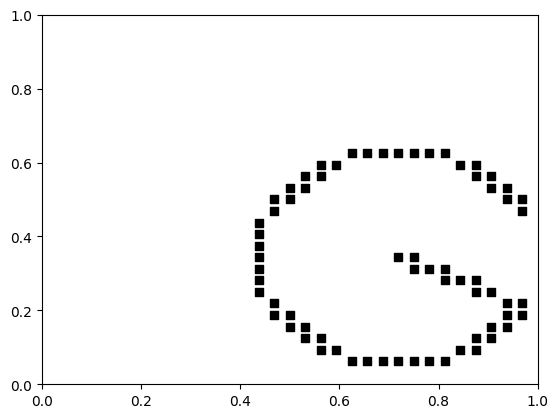

3


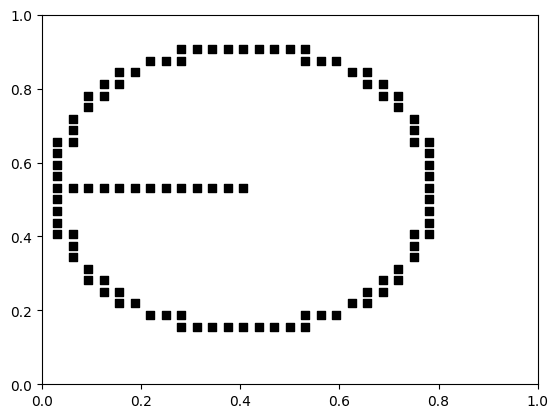

9


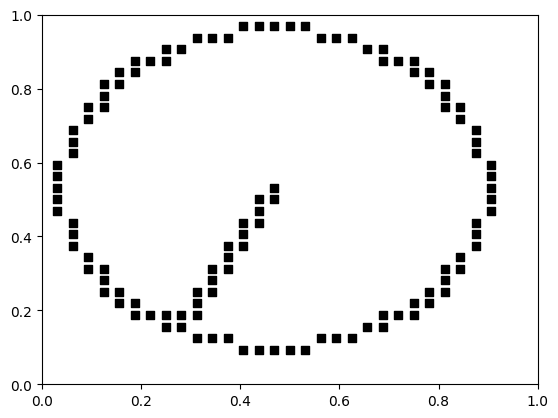

6


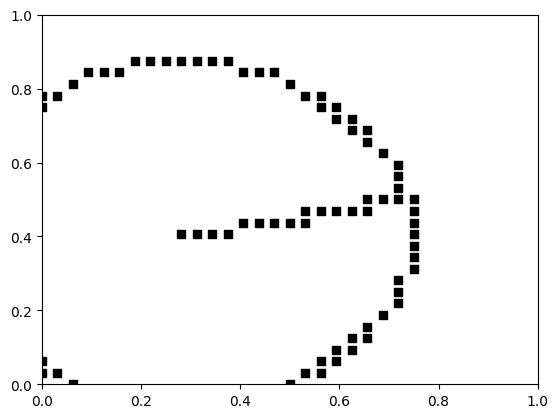

2


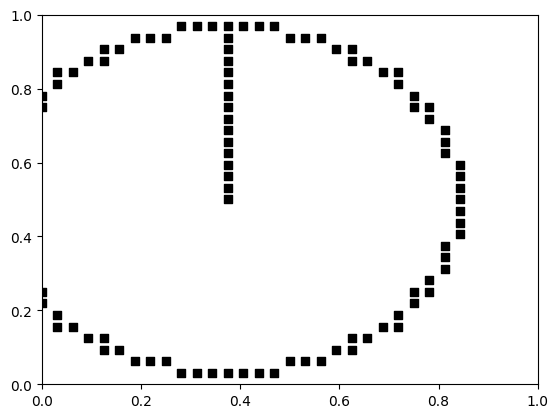

11


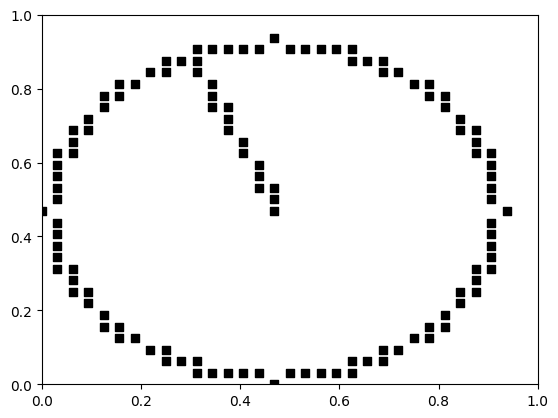

11


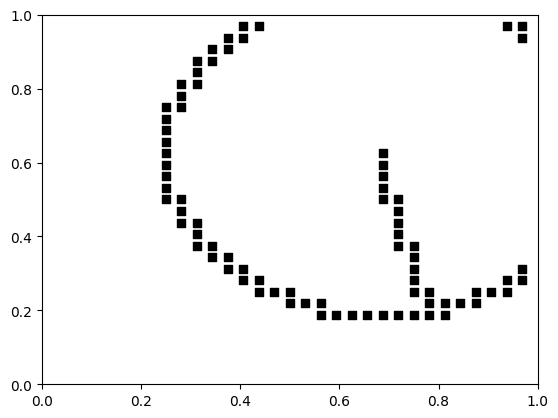

5


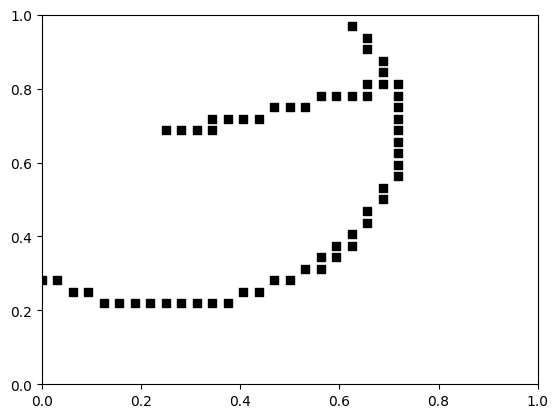

2


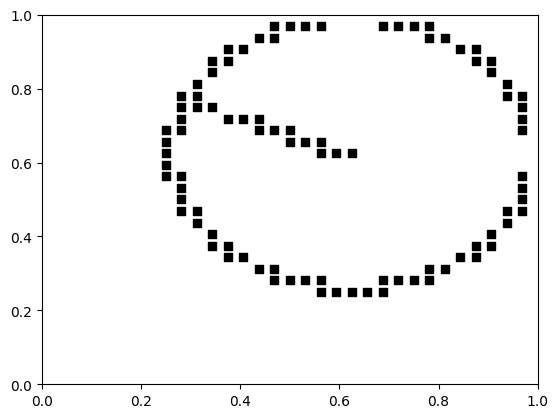

9


In [7]:
for i in range(10):
    pt_plt(x_test[i])
    print(t_test[i])